# Damped Simple Harmonic oscillator

## Import libraries

In [5]:
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn as nn

## The physics

Psuedo-Lagrangian (as technically, Lagrangian is only defined for complete closed systems, and a damped system is a dissipative system, thus its best to work with equation of motion) for simple harmonic oscillator

$$
L =   \frac{1}{2} m\left(\frac{dx}{dt}\right)^2 + \mu x \frac{dx}{dt} - \frac{1}{2} kx^2 
$$

Equation of motion (Euler Lagrange Equation) is given below

$$
m \dfrac{d^2x}{dt^2} + \mu \frac{dx}{dt}= -kx~.
$$

## Solving analytically

The exact solution to the damped harmonic oscillator equation depends on the type of damping. The general form of the equation is $m \frac{d²x}{dt²} + γ \frac{dx}{dt} + kx = 0$, where $m$ is the mass, $γ$ is the damping coefficient, $k$ is the spring constant, and $x$ is the displacement.

1. **Underdamped ($γ² < 4mk$)**: The system oscillates, but the amplitude of oscillation decreases over time. The solution is:

$$x(t) = e^{-\frac{γt}{2m}} [A \cos(ω_dt) + B \sin(ω_dt)]$$

where $ω_d = \frac{\sqrt{4mk - γ²}}{2m}$ is the damped angular frequency, and $A$ and $B$ are constants determined by initial conditions.

2. **Critically damped ($γ² = 4mk$)**: The system returns to equilibrium as quickly as possible without oscillating. The solution is:

$$x(t) = (A + Bt) e^{-\frac{γt}{2m}}$$

where $A$ and $B$ are constants determined by initial conditions.

3. **Overdamped ($γ² > 4mk$)**: The system returns to equilibrium without oscillating, but more slowly than the critically damped case. The solution is:

$$x(t) = e^{-\frac{γt}{2m}} [A e^{\frac{t\sqrt{γ² - 4mk}}{2m}} + B e^{-\frac{t\sqrt{γ² - 4mk}}{2m}}]$$

where $A$ and $B$ are constants determined by initial conditions.

Please note that these solutions assume that the right-hand side of the equation is zero, i.e., there are no external forces. If there are external forces, the solutions will be different.

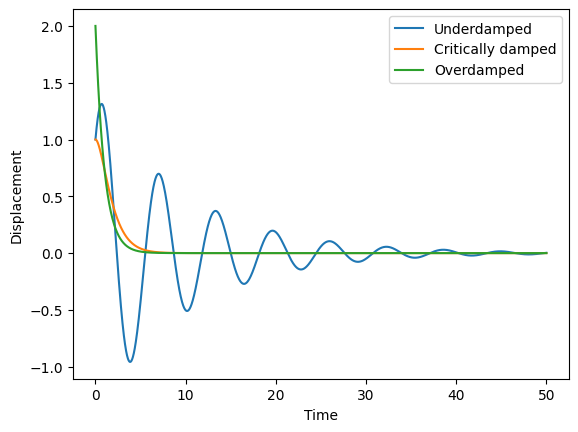

In [6]:
# Parameters
m = 1  # mass
k = 1  # spring constant
A = 1  # initial displacement
B = 1  # initial velocity
t = torch.linspace(0, 50, 2000, dtype=torch.float32).view(-1,1)  # time array

# Underdamped
gamma = 0.2  # damping coefficient
omega_d = np.sqrt(4*m*k - gamma**2) / (2*m)
x_underdamped = np.exp(-gamma*t/(2*m)) * (A * np.cos(omega_d*t) + B * np.sin(omega_d*t))
plt.plot(t, x_underdamped, label='Underdamped')

# Critically damped
gamma = np.sqrt(4*m*k)  # damping coefficient
x_critically_damped = (A + B*t) * np.exp(-gamma*t/(2*m))
plt.plot(t, x_critically_damped, label='Critically damped')

# Overdamped
gamma = 2  # damping coefficient
x_overdamped = np.exp(-gamma*t/(2*m)) * (A * np.exp(t*np.sqrt(gamma**2 - 4*m*k)/(2*m)) + B * np.exp(-t*np.sqrt(gamma**2 - 4*m*k)/(2*m)))
plt.plot(t, x_overdamped, label='Overdamped')

# Plot settings
plt.xlabel("Time")
plt.ylabel("Displacement")
plt.legend(loc="upper right")
plt.show()

## Solving with a NN

Lets try to fit a standard Neural network to some training data we get from our solution.

### Step 1: Create some training data from the known analytic solution

In [7]:
t_samples = t[:100:5]
x_underdamped_samples = x_underdamped[:100:5]
t_samples.dtype, x_underdamped_samples.dtype, t.dtype, x_underdamped.dtype

(torch.float32, torch.float32, torch.float32, torch.float32)

### Step 2: Create a standard Feed Forward Fully Connected Nueral network

In [8]:
class shoNN(torch.nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.input_layer = nn.Sequential(nn.Linear(N_INPUT, N_HIDDEN), activation())
        self.hidden_layers = nn.Sequential(*[nn.Sequential(nn.Linear(N_HIDDEN, N_HIDDEN), activation()) for _ in range(N_LAYERS-1)])
        self.output_layer = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.input_layer(x)
        x = self.hidden_layers(x)
        x = self.output_layer(x)
        return x


Before training the NN, lets visualise what we are about to do. The graph below shows the analytic solution in blue, which is an exact solution to the differential equation for a SHO. We have then sampled a subset of the solutions to the equation at specific times to create a training 'y' variable, and will be fed to the NN for training. 

Note that the training data onll covers a small subset of the full range of 'x' values. This is important as it highlights that we are not going to simply fit the NN to the functional data, rather a subset of the data and 'learn' the rest of the solution by providing it 'physical insight' directly into the loss function.

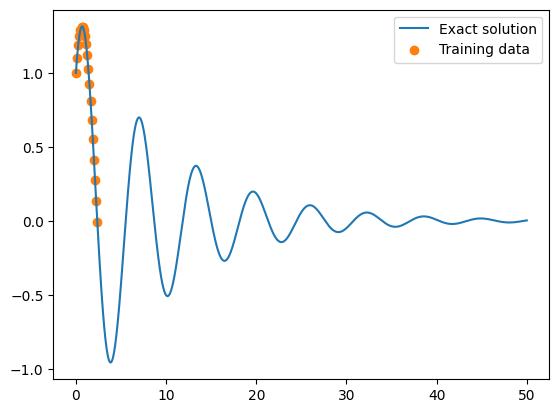

In [9]:
plt.figure()
plt.plot(t, x_underdamped, label="Exact solution")
plt.scatter(t_samples, x_underdamped_samples, color="tab:orange", label="Training data")
plt.legend()
plt.show()


### Step 3: Create some plotting functions for easy visualisation

In [10]:
def plot_result(x,y,x_data,y_data,yh,xp=None):
    "Pretty plot training results"
    plt.figure(figsize=(8,4))
    plt.plot(x,y, color="grey", linewidth=2, alpha=0.8, label="Exact solution")
    plt.plot(x,yh, color="tab:blue", linewidth=4, alpha=0.8, label="Neural network prediction")
    plt.scatter(x_data, y_data, s=60, color="tab:orange", alpha=0.4, label='Training data')
    if xp is not None:
        plt.scatter(xp, -0*torch.ones_like(xp), s=60, color="tab:green", alpha=0.4, 
                    label='Physics loss training locations')
    l = plt.legend(loc=(1.01,0.34), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    plt.xlim(-0.05, 1.05)
    plt.ylim(-1.1, 1.1)
    plt.text(1.065,0.7,"Training step: %i"%(i+1),fontsize="xx-large",color="k")
    plt.axis("off")

def save_gif_PIL(outfile, files, fps=5, loop=0):
    images = [Image.open(fn) for fn in files]
    images[0].save(outfile, save_all=True, append_images=images[1:], optimize=False, duration=1000/fps, loop=loop)

### Step 4: Train the NN on training data with a normal MSE loss

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


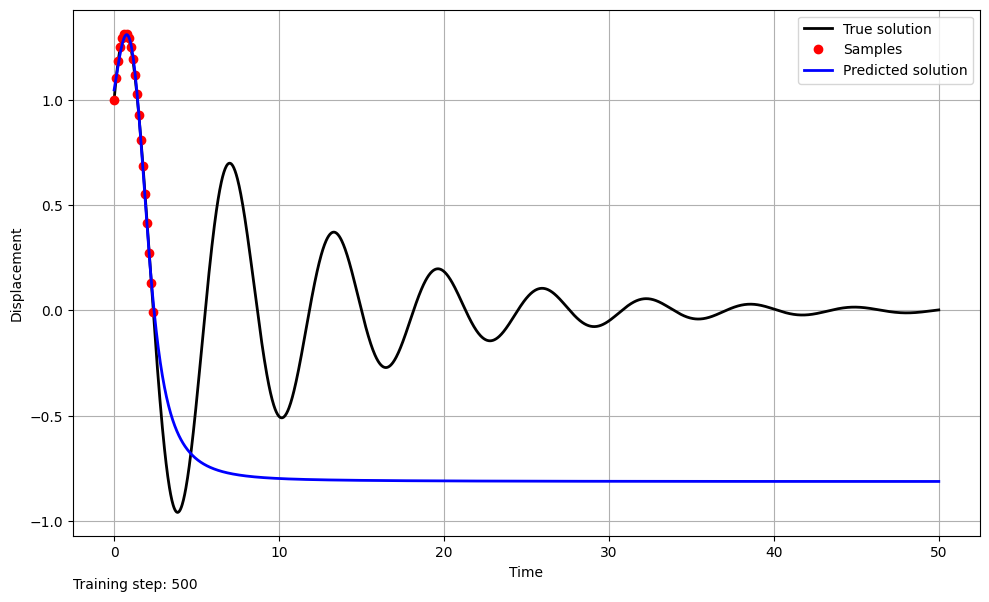

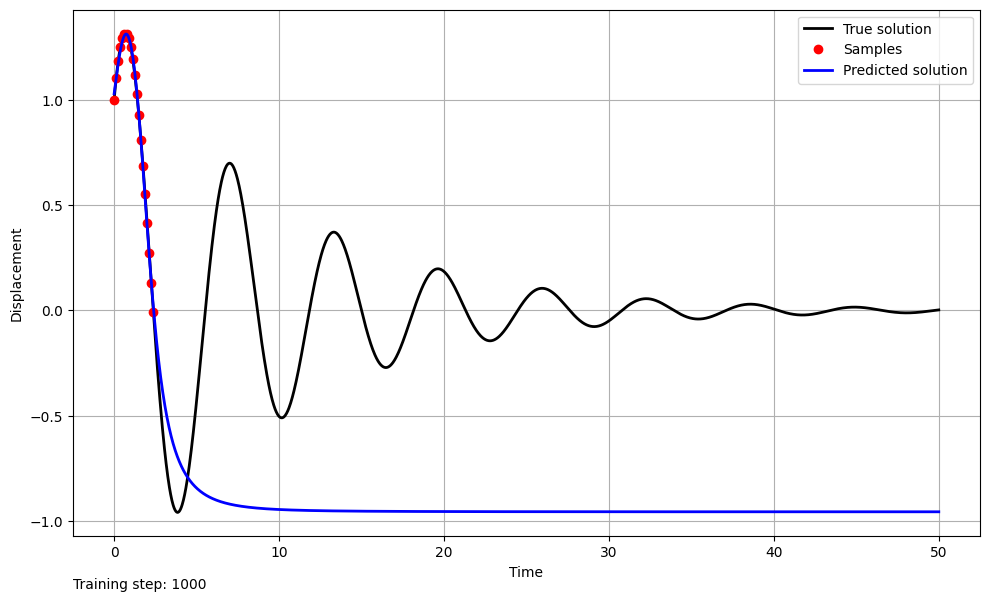

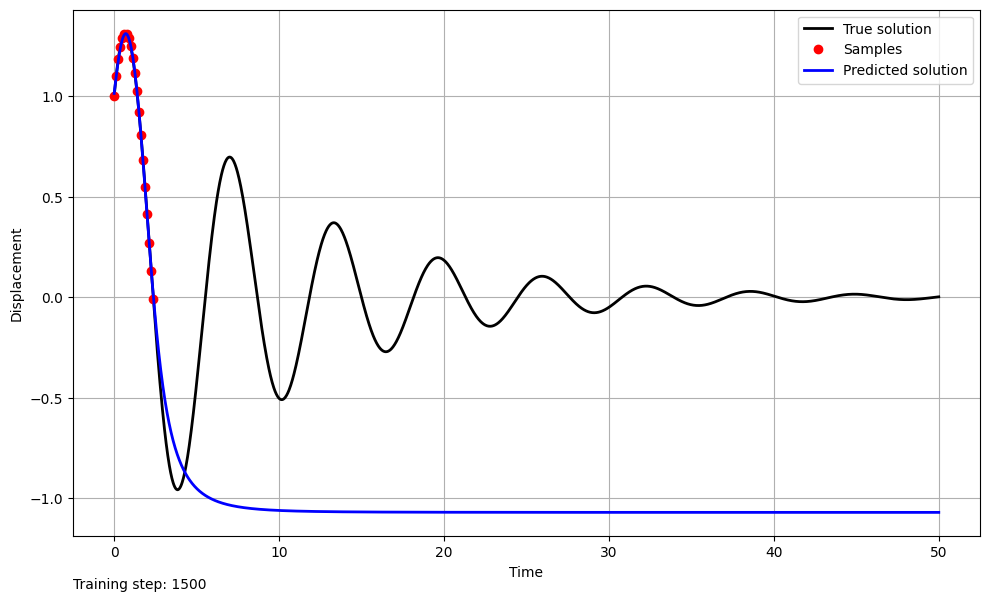

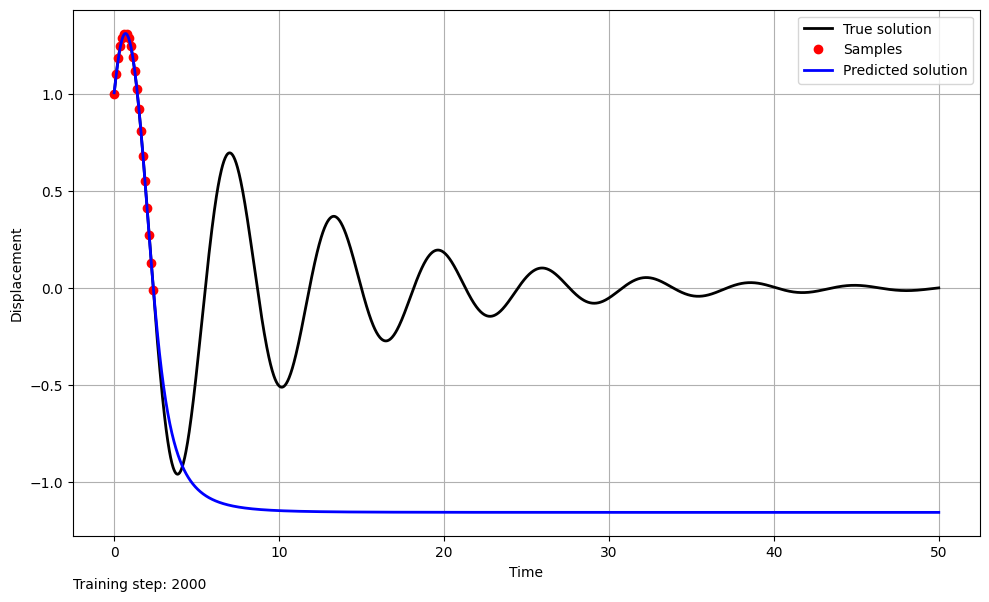

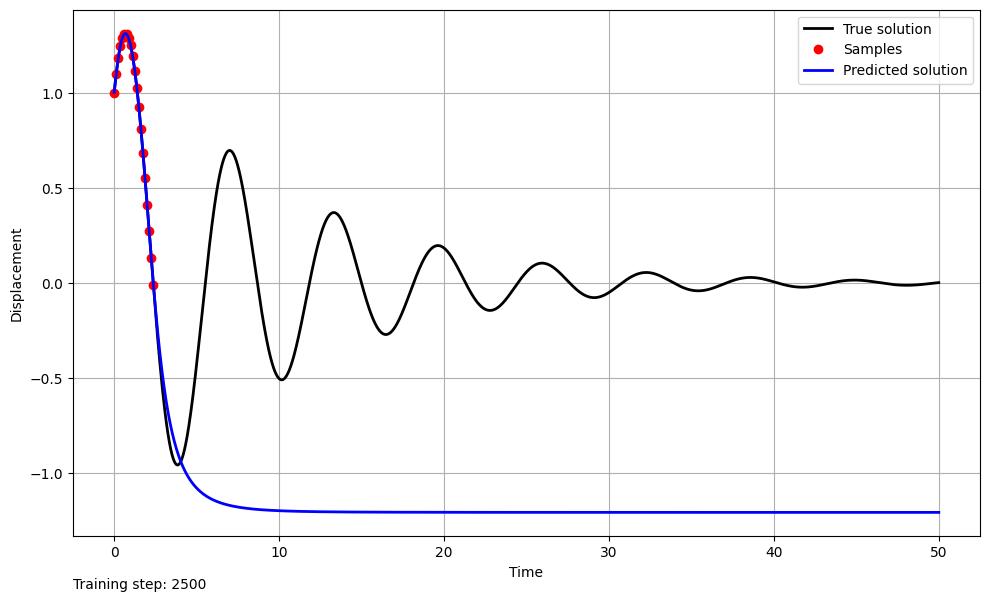

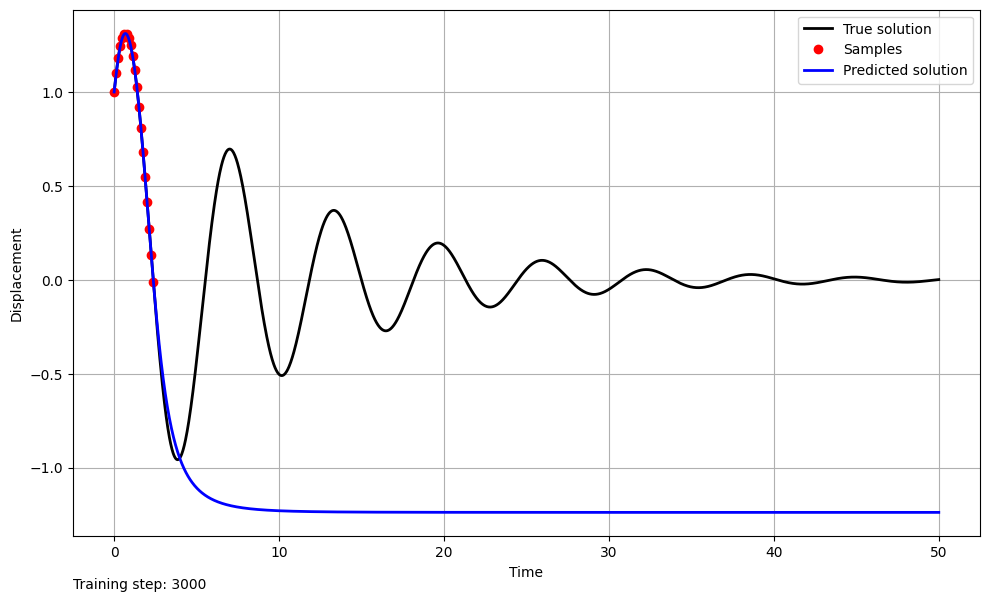

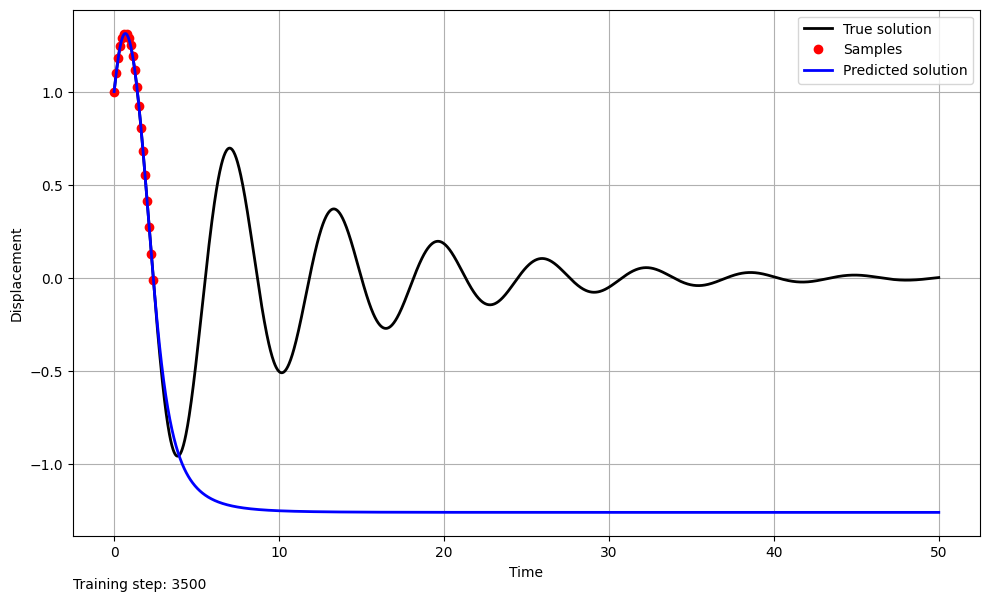

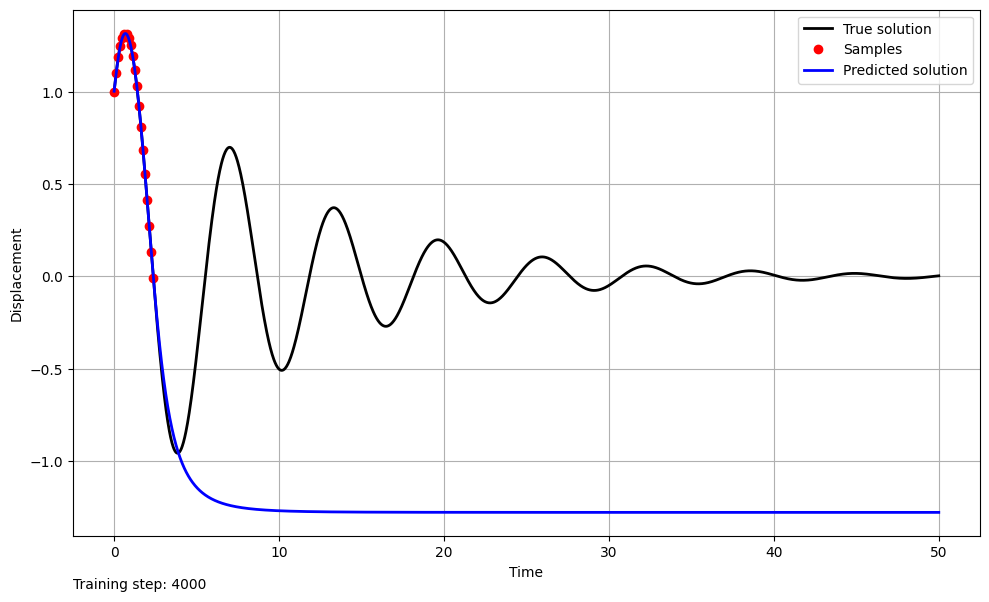

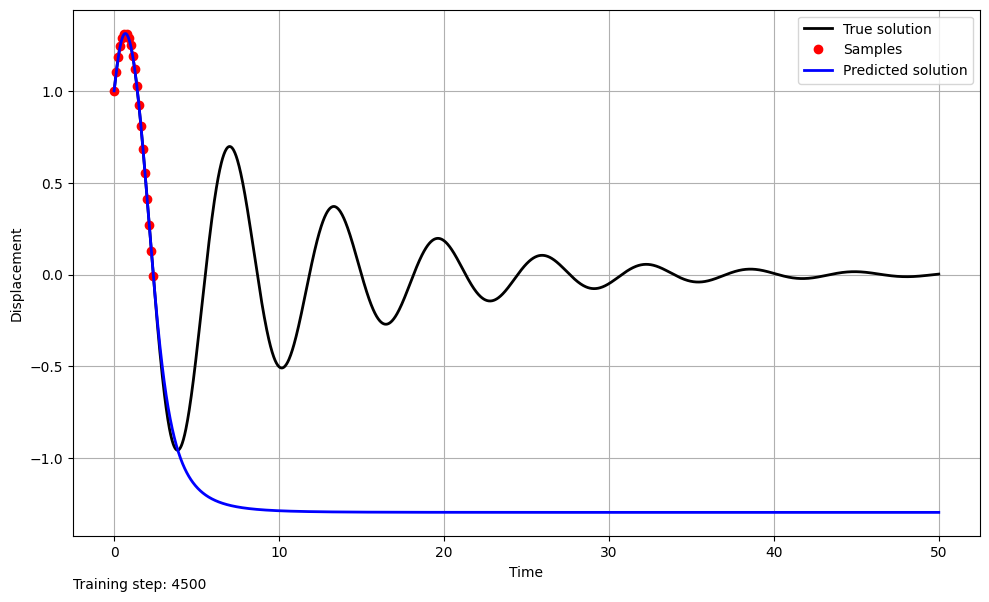

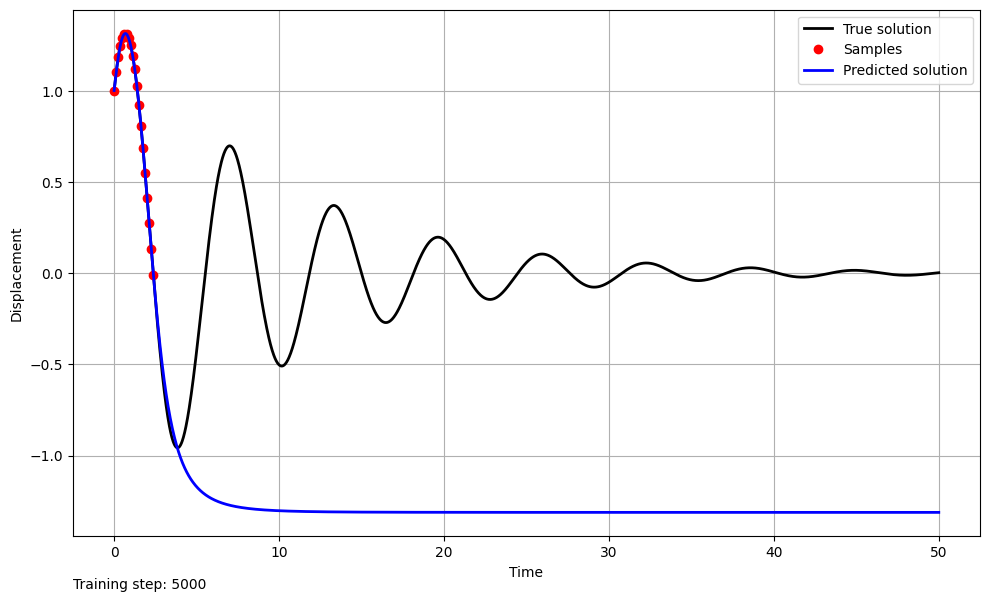

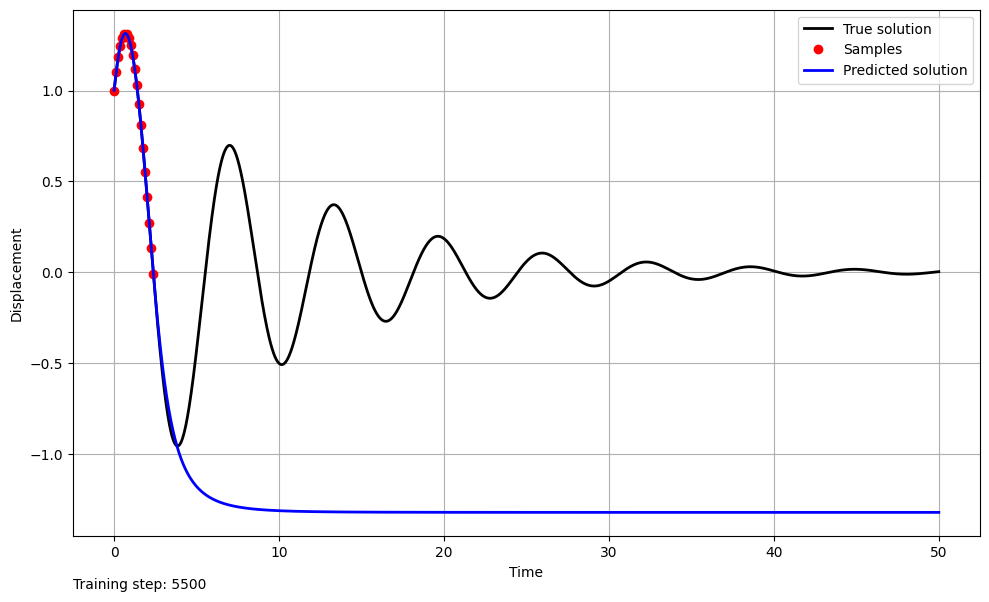

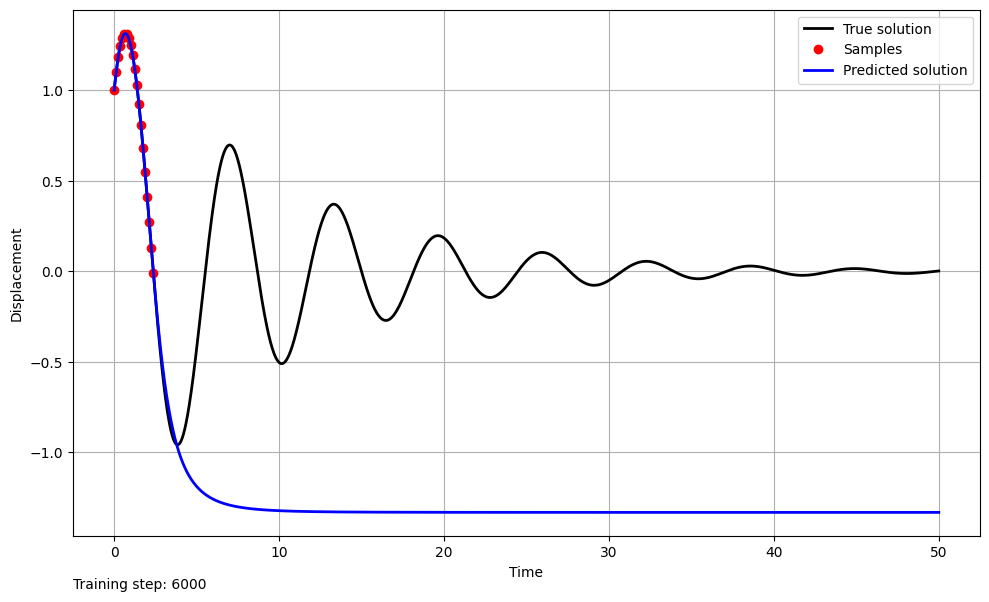

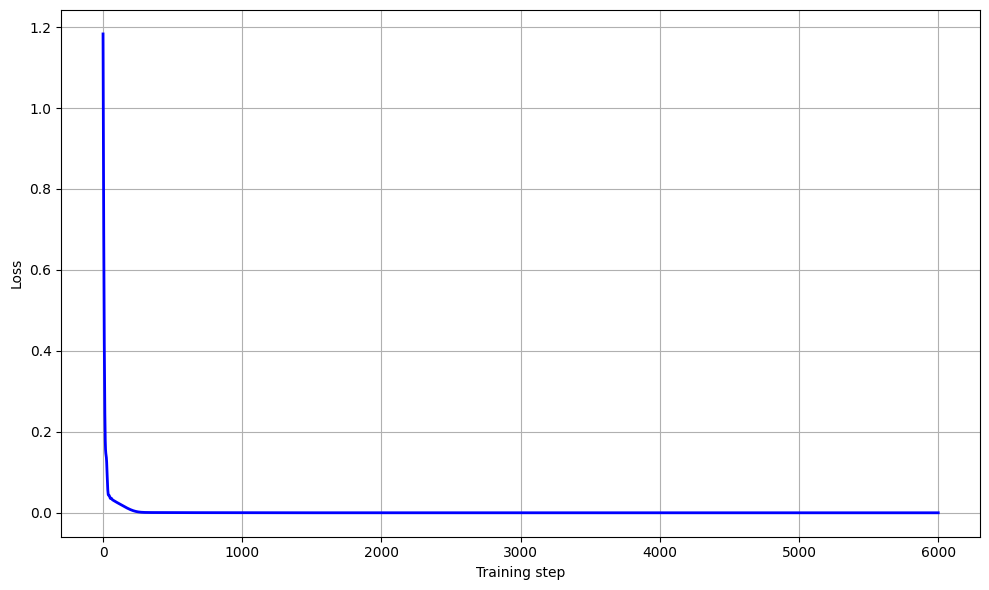

In [11]:
# train standard neural network to fit training data
torch.manual_seed(123)
model = shoNN(1,1,32,3)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
files = []
losses = []
for i in range(6000):
    optimizer.zero_grad()
    x_underdamped_samples_predicted = model(t_samples)
    loss = torch.mean((x_underdamped_samples_predicted-x_underdamped_samples)**2) # use mean squared error
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    
    # plot the result as training progresses
    if (i+1) % 10 == 0: 
        x_underdamped_samples_predicted_plot = model(t).detach()
        
        # Plotting
        plt.figure(figsize=(10, 6))  # Increase figure size
        plt.plot(t, x_underdamped, 'k-', linewidth=2, label='True solution')  # Black line for true solution
        plt.plot(t_samples, x_underdamped_samples, 'ro', label='Samples')  # Red dots for samples
        plt.plot(t, x_underdamped_samples_predicted_plot, 'b-', linewidth=2, label='Predicted solution')  # Blue line for predicted solution
        plt.xlabel("Time")
        plt.ylabel("Displacement")
        legend = plt.legend(loc="upper right")  # Get legend
        plt.grid(True)  # Add grid
        plt.tight_layout()  # Adjust subplot parameters

        # Get legend bounding box
        legend_box = legend.get_frame().get_bbox()

        # Add training step text below legend
        plt.text(legend_box.x0, legend_box.y0 - 0.1, 'Training step: {}'.format(i+1), transform=plt.gca().transAxes, horizontalalignment='left')
        
        file = "../plots/nn_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)
    
        if (i+1) % 500 == 0: 
            plt.show()
        else: 
            plt.close("all")

# Plotting loss
plt.figure(figsize=(10, 6))  # Increase figure size
plt.plot(losses, 'b-', linewidth=2)  # Blue line for loss
plt.xlabel("Training step")
plt.ylabel("Loss")
plt.grid(True)  # Add grid
plt.tight_layout()  # Adjust subplot parameters
plt.show()

save_gif_PIL("nn_no_underdamped_sholoss.gif", files, fps=20, loop=0)

Lets reflect on these results.
1. We see that the NN fits the training data we provided perfectly, which is no surprise as it has more than enough parameters (in fact, in this case more parameters than data points). So the system is completely overfit
2. We see that it tries to learn but the loss function platues fairly rapidly with no change with training steps. The final result is a model that simply cannot predict the unseen data

### Step 5: Train the NN with SHO and boundary term loss

The Damped Harmonic Oscillator (DHO) loss function is:

$$
L_{dho} = \frac{1}{N} \sum \left(\frac{d^2x}{dt^2} + 2\gamma \frac{dx}{dt} + \omega_0^2 x \right)^2
$$

And the boundary loss is:

$$
L_{boundary} = (x(t_{initial}) - x_0)^2 + \left( \frac{dx}{dt}(t_{initial}) - v_0 \right)^2
$$

where $t_{initial} = 0$. This simply says that the initial displacement is $x_0$ and the initial velocity is $v_0$.

In the DHO loss function, $\gamma$ is the damping coefficient and $\omega_0$ is the natural frequency of the oscillator. The term $2\gamma \frac{dx}{dt}$ represents the damping force which is proportional to the velocity of the oscillator and acts in the opposite direction.

Now lets train a NN with these loss terms and various example parameters

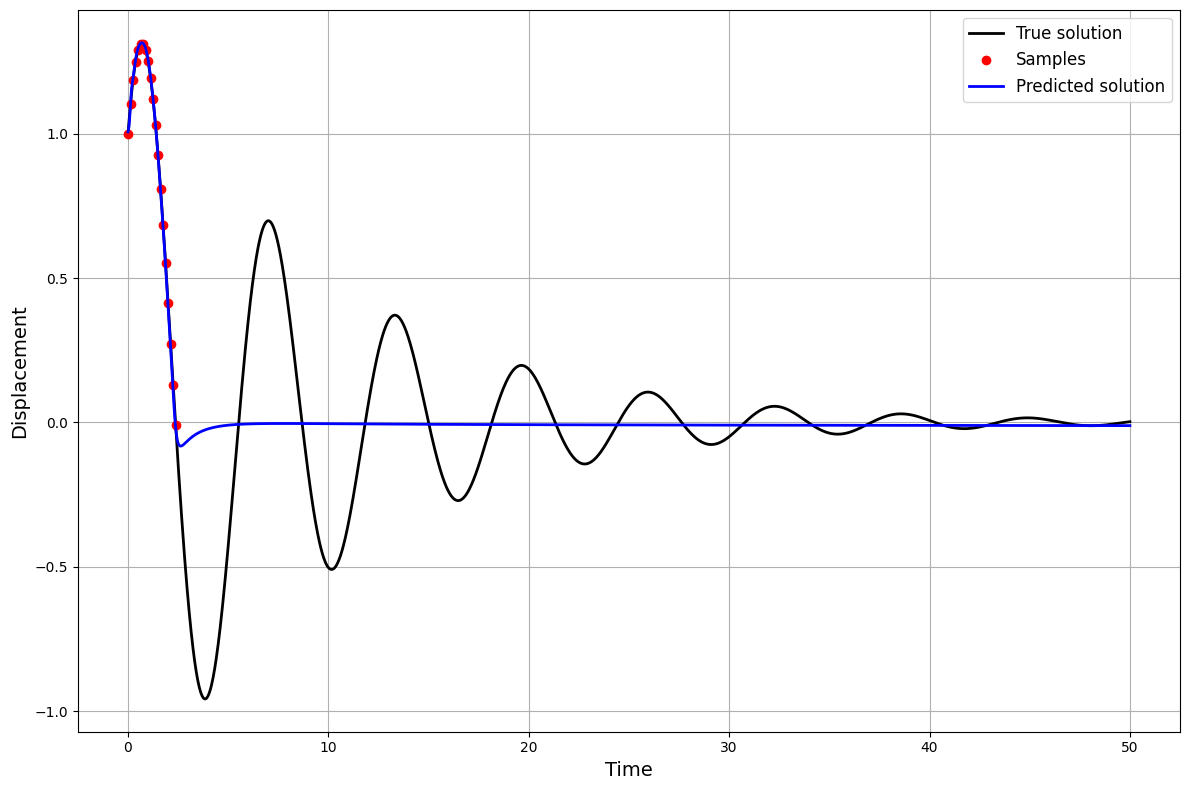

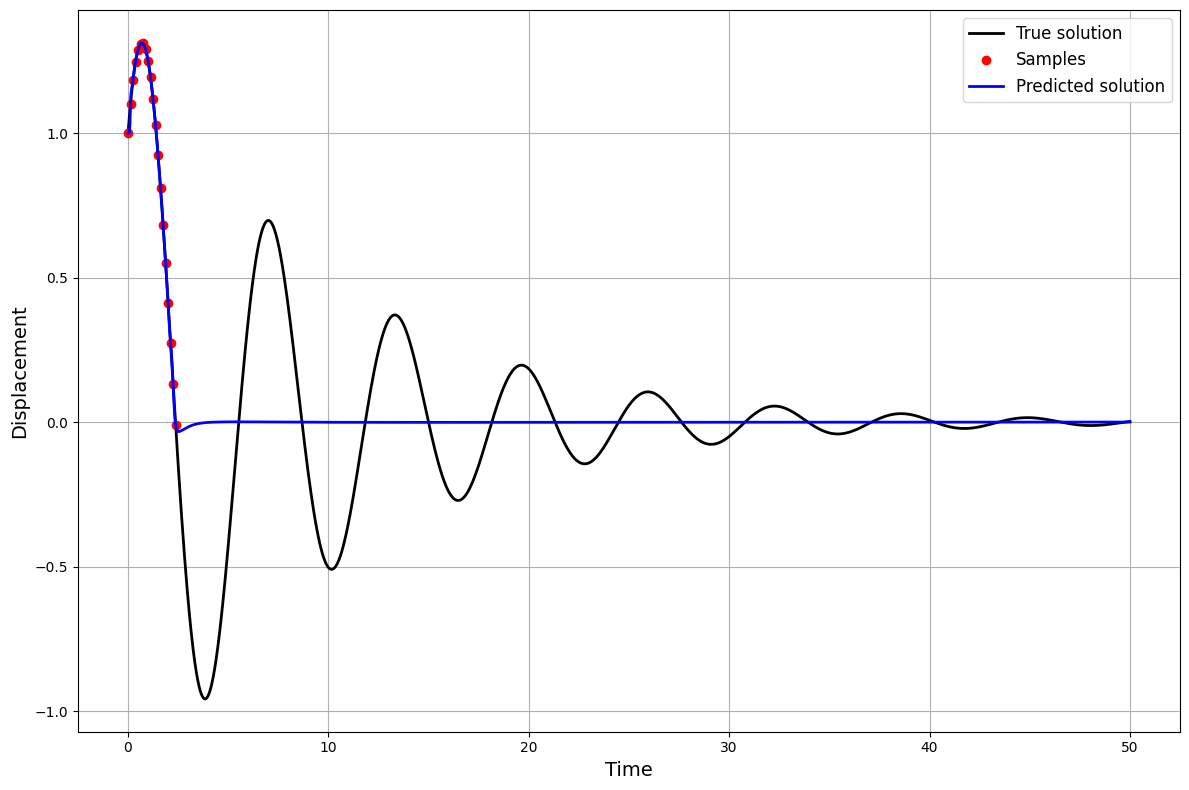

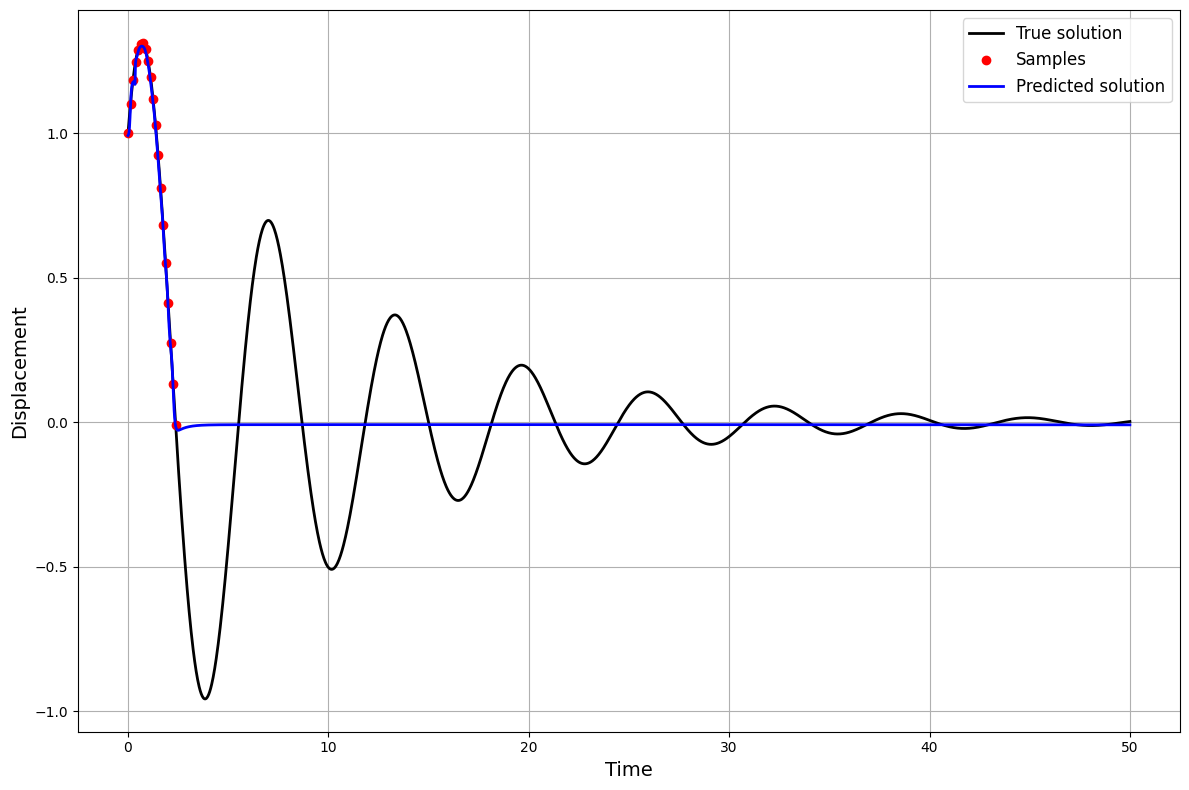

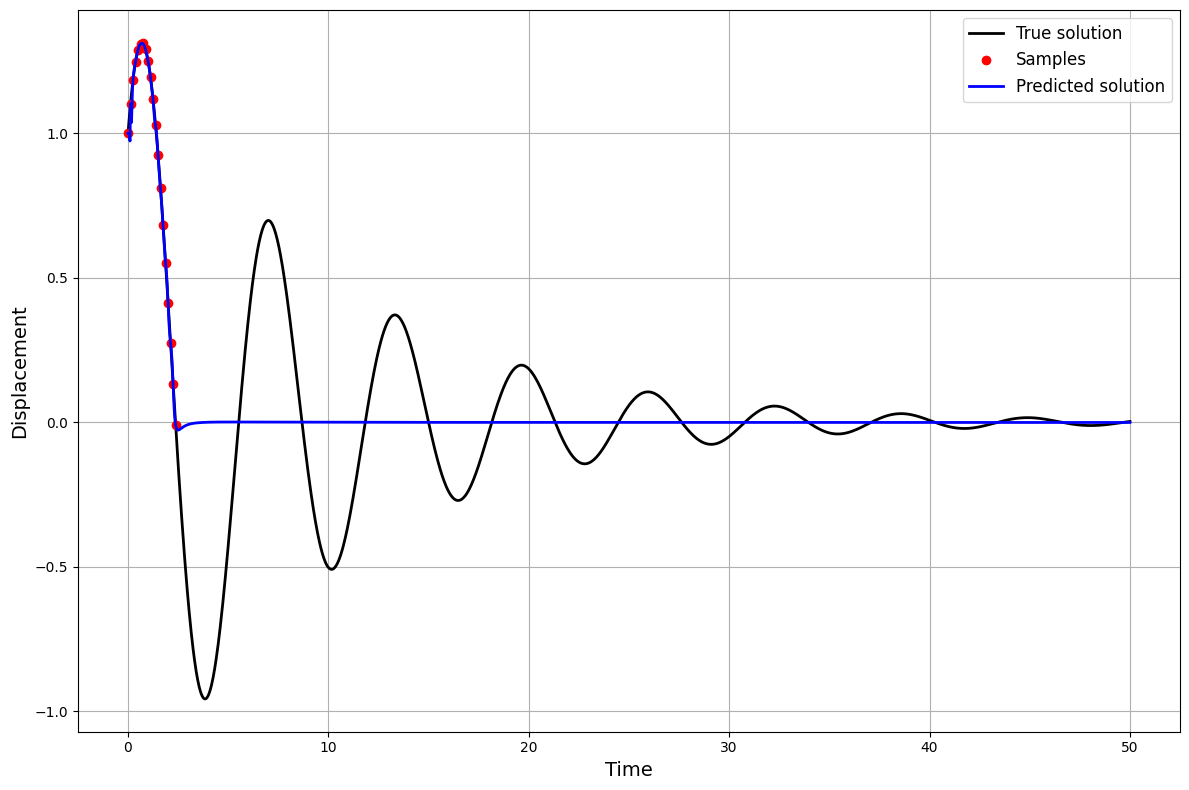

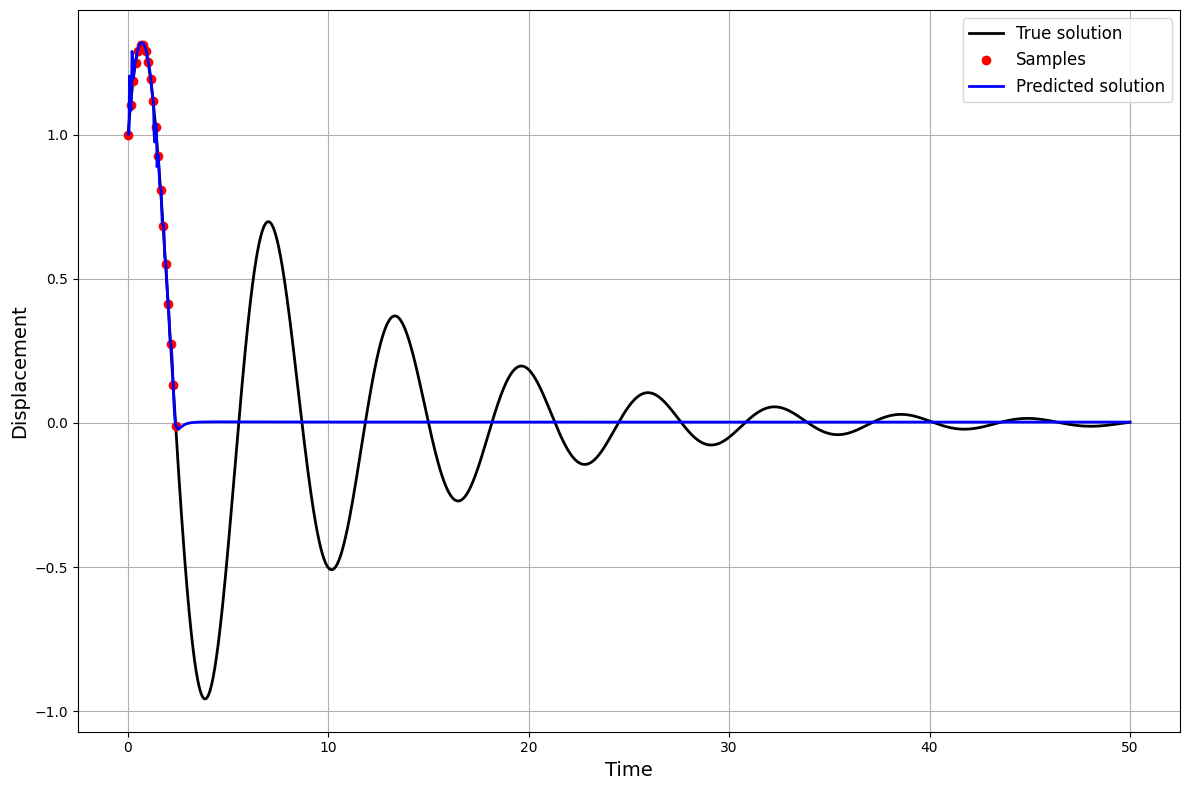

KeyboardInterrupt: 

In [22]:
t_with_grad = t.clone().detach().requires_grad_(True)
initial_time = torch.tensor(0.).view(-1,1).requires_grad_(True) # providing initial time = 0 for initial conditions, x(t)=1, dx/dt=0
torch.manual_seed(1)
model = shoNN(1,1,32,3)
files = []
dsho_loss_weight =  1e-8
initial_condition_loss_weight = 1e-4
frequency = 30
gamma = 0.1 # damping coefficient

optimizer = torch.optim.Adam(model.parameters(),lr=1e-2)

losses_physics = []
losses_dsho = []
losses_initial_condition = []

for i in range(60000):
    optimizer.zero_grad()
    dsho_predicted = model(t_samples)
    loss1 = torch.mean((dsho_predicted-x_underdamped_samples)**2) # use mean squared error

    dsho_predicted_physics = model(t_with_grad)
    dtdsho_predicted_physics = torch.autograd.grad(dsho_predicted_physics, t_with_grad, torch.ones_like(dsho_predicted_physics), create_graph=True)[0]
    d2tdsho_predicted_physics = torch.autograd.grad(dtdsho_predicted_physics, t_with_grad, torch.ones_like(dtdsho_predicted_physics), create_graph=True)[0]
    dsho_loss = torch.mean((d2tdsho_predicted_physics + 2*gamma*dtdsho_predicted_physics + frequency**2*dsho_predicted_physics)**2)

    initial_dsho_x = model(initial_time)
    initial_dsho_dt = torch.autograd.grad(initial_dsho_x, initial_time, torch.ones_like(initial_dsho_x), create_graph=True)[0]
    initial_condition_loss = (torch.squeeze(initial_dsho_x) - 1)**2 + (torch.squeeze(initial_dsho_dt))**2

    loss = loss1 + dsho_loss_weight*dsho_loss + initial_condition_loss_weight*initial_condition_loss
    loss.backward()
    optimizer.step()
    losses_dsho.append(dsho_loss.item())
    losses_initial_condition.append(initial_condition_loss.item())
    losses_physics.append(loss.item())

    if (i+1) % 150 == 0:
        dsho_predicted_plot = model(t).detach()

        plt.figure(figsize=(12, 8))  # Increase figure size
        plt.plot(t, x_underdamped, 'k-', linewidth=2, label='True solution')  # Black line for true solution
        plt.plot(t_samples, x_underdamped_samples, 'ro', label='Samples')  # Red dots for samples
        plt.plot(t, dsho_predicted_plot, 'b-', linewidth=2, label='Predicted solution')  # Blue line for predicted solution
        plt.xlabel("Time", fontsize=14)
        plt.ylabel("Displacement", fontsize=14)
        plt.legend(loc="upper right", fontsize=12)  # Get legend
        plt.grid(True)  # Add grid
        plt.tight_layout()  # Adjust subplot parameters

        file = "../plots/nn_physics_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)

        if (i+1) % 6000 == 0:
            plt.show()
        else: 
            plt.close("all")

# Plotting loss
plt.figure(figsize=(12, 8))  # Increase figure size
plt.plot(losses_physics, 'b-', linewidth=2, label="Physics loss")  # Blue line for physics loss
plt.plot(losses_dsho, 'r-', linewidth=2, label="DSHO loss")  # Red line for DSHO loss
plt.plot(losses_initial_condition, 'g-', linewidth=2, label="Initial condition loss")  # Green line for initial condition loss
plt.xlabel("Training step", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.yscale("log")
plt.grid(True)  # Add grid
plt.legend(loc="upper right", fontsize=12)  # Get legend
plt.tight_layout()  # Adjust subplot parameters
plt.show()

save_gif_PIL('physics_nn.gif', files, fps=20, loop=0)